<a href="https://colab.research.google.com/github/jnmaloof/DeepLearning_JulinMaloof/blob/main/Flowers_R_Kefras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab notebook for trying to classify flowers

This is an R script.  See this [info on how to start an R script in colab](https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497)


Dataset is from kaggle [here](https://www.kaggle.com/rishitchs/final-flowers-course-project-dataset)

## Installations and setup

In [1]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [2]:
library(keras)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## get data from google drive

If you upload your zipped file to google drive, then you can download it using the comands here. 

Your other alternative is to upload it from your laptop, but that is slower.

Either way, the data will have to be uploaded/downloaded every time, because we can't mount the google drive to an R runtime.



In [3]:
install.packages("googledrive")
library("googledrive")

# this next step is required to authenticate google drive.
# Check if is running in Colab and redefine is_interactive()
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

drive_auth(use_oob = TRUE, cache = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following object is masked from ‘package:keras’:

    compile


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:tidyr’:

    extract




Enter authorization code: 4/1AY0e-g5rrOGPsa-5Jo_mg9GbxaXjyTCTFUyTkTFbJQbWDfgO__fu0zu_bpY


In [4]:
flowersInfo <- drive_find("newFlowers\\.zip", n_max = 1)
flowersInfo[,1:2]
flowersID <- flowersInfo$id

name,id
<chr>,<chr>
newFlowers.zip,1BD_NgV6hytm-D4xtO4JPzwExPcGyh5MI


In [5]:
drive_download(file=as_id(flowersID))
dir()

File downloaded:
  * newFlowers.zip
Saved locally as:
  * newFlowers.zip



[1] "newFlowers.zip" "sample_data"

In [6]:
detach("package:R.utils")
detach("package:R.oo")

## set up data and directories

In [7]:
utils::unzip("newFlowers.zip")
flowers <- dir(path = "newFlowers")
flowers

[1] "daisy"     "dandelion" "rose"      "sunflower" "tulip"

In [8]:
#tmp as a holder for the T/F that come out of these

tmp <- if(dir.exists("train")) file.remove(dir(path = "train/", full.names = TRUE, recursive = TRUE))
tmp <- if(dir.exists("test")) file.remove(dir(path = "test/", full.names = TRUE, recursive = TRUE))
tmp <- if(dir.exists("validation")) file.remove(dir(path = "validation/", full.names = TRUE, recursive = TRUE))

tmp <- if(!dir.exists("train")) dir.create("train/")
tmp <- if(!dir.exists("test")) dir.create("test/")
tmp <- if(!dir.exists("validation")) dir.create("validation/")

tmp <- map(flowers, ~ if(!dir.exists(file.path("train", .x)))
                  dir.create(file.path("train", .x ))
                  )
    
tmp <- map(flowers, ~ if(!dir.exists(file.path("test", .x)))
                  dir.create(file.path("test", .x ))
                  )
    
tmp <- map(flowers, ~ if(!dir.exists(file.path("validation", .x)))
                  dir.create(file.path("validation", .x ))
                  )



In [9]:
# populate directories
set.seed(2023)
sourcedir <- "newFlowers"
for(flower in flowers) {
  files <- sample(dir(file.path(sourcedir, flower))) #randomizes
    for(i in 1:length(files)) {
      if (i/length(files) <= 0.2 ) destination <- "validation"
      if (i/length(files) > 0.2 & i/length(files) <= 0.4) destination <- "test"
      if (i/length(files) > 0.4 ) destination <- "train"
      file.copy(from = file.path(sourcedir, flower, files[i]), 
                to = file.path( destination, flower, files[i]))
    } # i loop              
} # flower loop

In [10]:
head(dir("train/rose"))
head(dir("test/rose"))
head(dir("validation/rose"))

length(dir("test/rose"))
length(dir("train/rose"))
length(dir("validation/rose"))


[1] "10090824183_d02c613f10_m.jpg" "110472418_87b6a3aa98_m.jpg"  
[3] "11102341464_508d558dfc_n.jpg" "11233672494_d8bf0a3dbf_n.jpg"
[5] "118974357_0faa23cce9_n.jpg"   "11944957684_2cc806276e.jpg"

[1] "10894627425_ec76bbc757_n.jpg" "12238827553_cf427bfd51_n.jpg"
[3] "12395698413_c0388278f7.jpg"   "13264214185_d6aa79b3bd.jpg"  
[5] "13929462317_96342a9a44.jpg"   "14019883858_e5d2a0ec10_n.jpg"

[1] "102501987_3cdb8e5394_n.jpg"   "10503217854_e66a804309.jpg"  
[3] "12240303_80d87f77a3_n.jpg"    "12243068283_ee4c2683e2_n.jpg"
[5] "12243069253_e512464095_n.jpg" "123128873_546b8b7355_n.jpg"

[1] 146

[1] 437

[1] 145

## Set up image generators 1


In [12]:
rescale_datagen <- image_data_generator(rescale = 1/255)


train_generator <- flow_images_from_directory(
    "train",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)
)

validation_generator <- flow_images_from_directory(
    "validation",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)
)

test_generator <- flow_images_from_directory(
    "test",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)

)

## Set up Model 1

In [13]:
model1 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(150,150,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model1 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

summary(model1)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_3 (Conv2D)                   (None, 148, 148, 32)            896         
________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)      (None, 74, 74, 32)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 72, 72, 64)              18496       
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 36, 36, 64)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 34, 34, 128)             73856       
________________________________________________________________________________
max_pool

In [14]:
# first: how many images do we have?
length(dir("train", recursive = TRUE))

# 2482, and we are using a batch size of 32, so we should use
2482/16 #155 steps per epoch

# how many validation images?
length(dir("validation", recursive = TRUE)) #825
825/16 #51 validation steps

[1] 2482

[1] 155.125

[1] 825

[1] 51.5625

In [15]:
system.time(history <- model1 %>% fit(
        train_generator,
        steps_per_epoch = 155,
        epochs = 30,
        validation_data = validation_generator,
        validation_steps = 51))

save_model_hdf5(model1, "flowers_model1_ep30.hdf5")
drive_put("flowers_model1_ep30.hdf5", "DeepLearning/Flowers/flowers_model1_ep30.hdf5")
file.remove("flowers_model1_ep30.hdf5")

history

Warning message in fit_generator(., train_generator, steps_per_epoch = 155, epochs = 30, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


   user  system elapsed 
393.554  50.074 346.866 


Final epoch (plot to see history):
    loss: 0.08353
     acc: 0.985
val_loss: 5.117
 val_acc: 0.6569 

`geom_smooth()` using formula 'y ~ x'



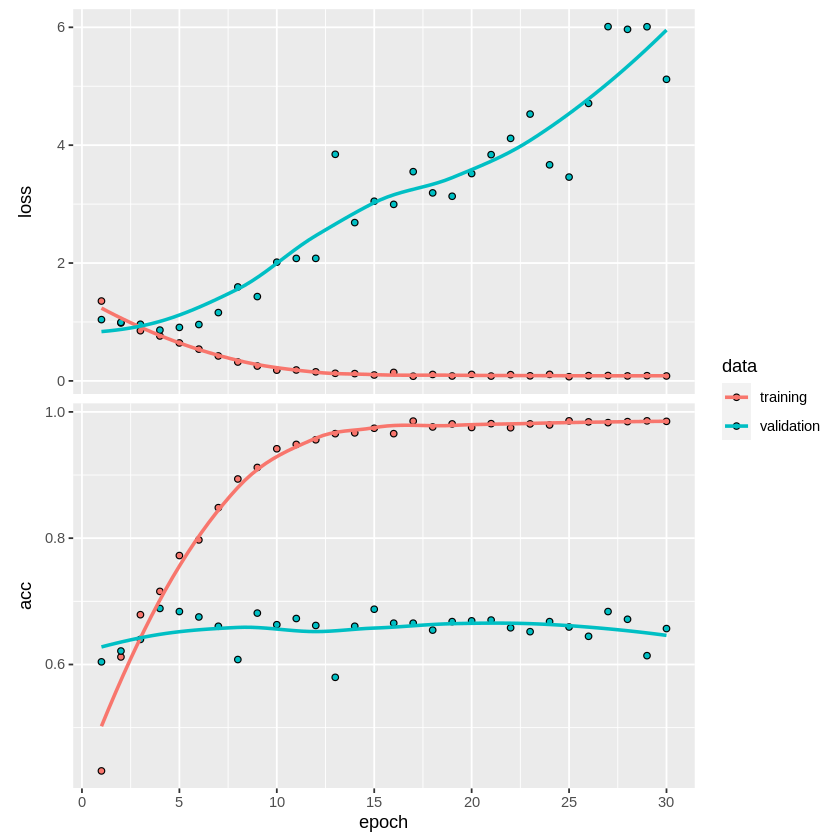

In [17]:
plot(history)

OK maybe 7 epochs is about where validation maxes out.  So refit for 7 epochs and check test.


In [30]:
model1 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(150,150,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model1 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

system.time(history <- model1 %>% fit_generator(
        train_generator,
        steps_per_epoch = 155,
        epochs = 7,
        validation_data = validation_generator,
        validation_steps = 51))

save_model_hdf5(model1, "flowers_model1_ep7.hdf5")
drive_put("flowers_model1_ep7.hdf5", "DeepLearning/Flowers/flowers_model1_ep7.hdf5")
file.remove("flowers_model1_ep7.hdf5")

history

Warning message in fit_generator(., train_generator, steps_per_epoch = 155, epochs = 7, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


   user  system elapsed 
 74.133   7.003  62.047 


Final epoch (plot to see history):
    loss: 0.4267
     acc: 0.8483
val_loss: 1.077
 val_acc: 0.6961 

In [32]:
results1 <- model1 %>% evaluate(test_generator)
results1 %>% round(3)

loss   acc 
1.003 0.680

## Set up image generators 2

Here use larger images, larger batch size, and an additional model layer


In [19]:
rescale_datagen <- image_data_generator(rescale = 1/255)


train_generator2 <- flow_images_from_directory(
    "train",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)
)

validation_generator2 <- flow_images_from_directory(
    "validation",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)
)

test_generator2 <- flow_images_from_directory(
    "test",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)

)

## Set up Model 2

In [20]:
model2 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(256,256,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model2 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

summary(model2)

Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_24 (Conv2D)                  (None, 254, 254, 32)            896         
________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D)     (None, 127, 127, 32)            0           
________________________________________________________________________________
conv2d_23 (Conv2D)                  (None, 125, 125, 64)            18496       
________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D)     (None, 62, 62, 64)              0           
________________________________________________________________________________
conv2d_22 (Conv2D)                  (None, 60, 60, 128)             73856       
________________________________________________________________________________
max_po

In [21]:
# first: how many images do we have?
length(dir("train", recursive = TRUE))

# 2482, and we are using a batch size of 32, so we should use
2482/32 #78 steps per epoch

# how many validation images?
length(dir("validation", recursive = TRUE)) #825
825/32 #26 validation steps

[1] 2482

[1] 77.5625

[1] 825

[1] 25.78125

In [22]:
system.time(history2 <- model2 %>% fit(
        train_generator2,
        steps_per_epoch = 78,
        epochs = 30,
        validation_data = validation_generator2,
        validation_steps = 26))

history2

   user  system elapsed 
396.006  45.980 336.075 


Final epoch (plot to see history):
    loss: 0.05112
     acc: 0.9855
val_loss: 5.232
 val_acc: 0.6473 

`geom_smooth()` using formula 'y ~ x'



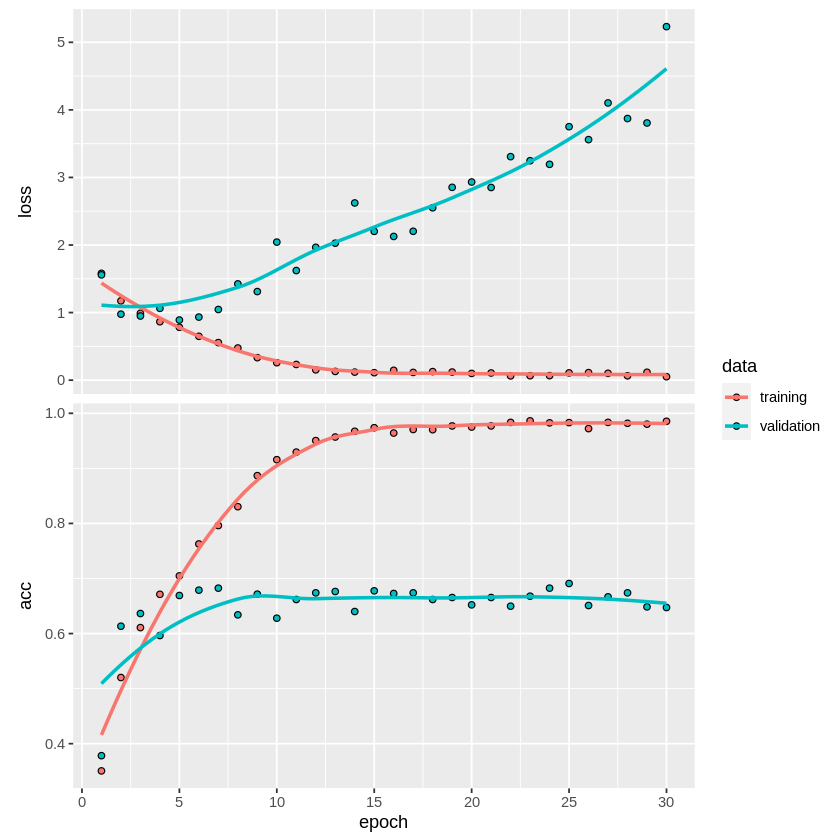

In [23]:
plot(history2)

Refit at 5 epochs

In [33]:
model2 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(256,256,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model2 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

system.time(history2 <- model2 %>% fit(
        train_generator2,
        steps_per_epoch = 78,
        epochs = 5,
        validation_data = validation_generator2,
        validation_steps = 26))

save_model_hdf5(model2, "flowers_model2_ep5.hdf5")
drive_put("flowers_model2_ep5.hdf5", "DeepLearning/Flowers/flowers_model2_ep5.hdf5")
file.remove("flowers_model2_ep5.hdf5")

history2


   user  system elapsed 
 66.272   7.353  55.806 


Final epoch (plot to see history):
    loss: 0.7979
     acc: 0.6906
val_loss: 0.8985
 val_acc: 0.6691 

In [34]:
results2 <- model2 %>% evaluate(test_generator2)
results2 %>% round(3)

loss   acc 
0.867 0.665

## Set up image generators 3: augmentation

Like model 2, but with augmentation

In [11]:
rescale_datagen <- image_data_generator(rescale = 1/255)

augment_datagen <- image_data_generator(rescale = 1/255,
  rotation_range=90,
  width_shift_range=.2,
  height_shift_range=.2,
  shear_range=.2,
  zoom_range=.2,
  horizontal_flip=TRUE)

train_generator3 <- flow_images_from_directory(
    "train",
    augment_datagen,
    batch_size=32,
    target_size=c(256,256)
)

validation_generator3 <- flow_images_from_directory(
    "validation",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)
)

test_generator3 <- flow_images_from_directory(
    "test",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)

)

## Set up Model 3

In [12]:
model3 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(256,256,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model3 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

summary(model3)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_4 (Conv2D)                   (None, 254, 254, 32)            896         
________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)      (None, 127, 127, 32)            0           
________________________________________________________________________________
conv2d_3 (Conv2D)                   (None, 125, 125, 64)            18496       
________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)      (None, 62, 62, 64)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 60, 60, 128)             73856       
________________________________________________________________________________
max_pool

### Train the model.  Here I am going to save it out every 10 epochs.

Previous runs showed that it was still improving at epoch 50, so will run 150 and save every 10 so that I don't need to refit.

In [13]:
total_epochs <- 150 
save_interval <- 10
#i <- 1
save_seq <- seq(from=save_interval, to=total_epochs, by=save_interval)

history3_list <- list()

system.time(for(i in save_seq) {
  history3_tmp <- model3 %>% fit(
        train_generator3,
        steps_per_epoch = 78,
        epochs = save_interval,
        validation_data = validation_generator3,
        validation_steps = 26)

  history3_list[[i/save_interval]] <- history3_tmp$metrics # all we need is metrics

  file_name <- str_c("flowers_model3_ep", i, ".hdf5")
  save_model_hdf5(model3, file_name)
  drive_put(file_name, str_c("DeepLearning/Flowers/", file_name), verbose=FALSE)
  file.remove(file_name)
  save(history3_list, file="history3_list.Rdata")
  drive_put("history3_list.Rdata", "DeepLearning/Flowers/history3_list.Rdata", verbose=FALSE)
  print(str_c("completed epoch: ", i))
})


[1] "completed epoch: 10"
[1] "completed epoch: 20"
[1] "completed epoch: 30"
[1] "completed epoch: 40"
[1] "completed epoch: 50"
[1] "completed epoch: 60"


Auto-refreshing stale OAuth token.



[1] "completed epoch: 70"
[1] "completed epoch: 80"
[1] "completed epoch: 90"
[1] "completed epoch: 100"
[1] "completed epoch: 110"
[1] "completed epoch: 120"
[1] "completed epoch: 130"


Auto-refreshing stale OAuth token.



[1] "completed epoch: 140"
[1] "completed epoch: 150"


    user   system  elapsed 
6691.726  151.911 8192.831 

In [14]:
if(!file.exists("history3_list.Rdata")) {
  drive_download("history3_list.Rdata")
}
str(history3_list)

List of 15
 $ :List of 4
  ..$ loss    : num [1:10] 1.583 1.245 1.099 1.011 0.964 ...
  ..$ acc     : num [1:10] 0.323 0.479 0.558 0.604 0.63 ...
  ..$ val_loss: num [1:10] 1.251 1.238 0.939 1.046 0.907 ...
  ..$ val_acc : num [1:10] 0.49 0.455 0.628 0.605 0.635 ...
 $ :List of 4
  ..$ loss    : num [1:10] 0.805 0.78 0.772 0.731 0.763 ...
  ..$ acc     : num [1:10] 0.687 0.702 0.708 0.724 0.707 ...
  ..$ val_loss: num [1:10] 0.778 0.807 1 0.737 0.806 ...
  ..$ val_acc : num [1:10] 0.714 0.719 0.679 0.737 0.71 ...
 $ :List of 4
  ..$ loss    : num [1:10] 0.67 0.672 0.658 0.668 0.601 ...
  ..$ acc     : num [1:10] 0.747 0.752 0.759 0.772 0.768 ...
  ..$ val_loss: num [1:10] 0.713 0.647 0.818 0.63 0.754 ...
  ..$ val_acc : num [1:10] 0.755 0.773 0.739 0.792 0.756 ...
 $ :List of 4
  ..$ loss    : num [1:10] 0.59 0.659 0.584 0.58 0.587 ...
  ..$ acc     : num [1:10] 0.786 0.769 0.788 0.781 0.786 ...
  ..$ val_loss: num [1:10] 0.84 0.73 0.75 0.602 1.424 ...
  ..$ val_acc : num [1:10] 0.73 0

In [20]:
history3 <- bind_rows(history3_list) %>%
  mutate(epoch=1:nrow(.))
dim(history3)
head(history3)

[1] 150   5

loss,acc,val_loss,val_acc,epoch
<dbl>,<dbl>,<dbl>,<dbl>,<int>
1.5831740,0.3227236,1.2506963,0.4896970,1
1.2448081,0.4794520,1.2377491,0.4545455,2
1.0988530,0.5584207,0.9389179,0.6278788,3
1.0111643,0.6035455,1.0459580,0.6048485,4
0.9641103,0.6301370,0.9074947,0.6351515,5
0.9292060,0.6345689,0.8676798,0.6484848,6


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



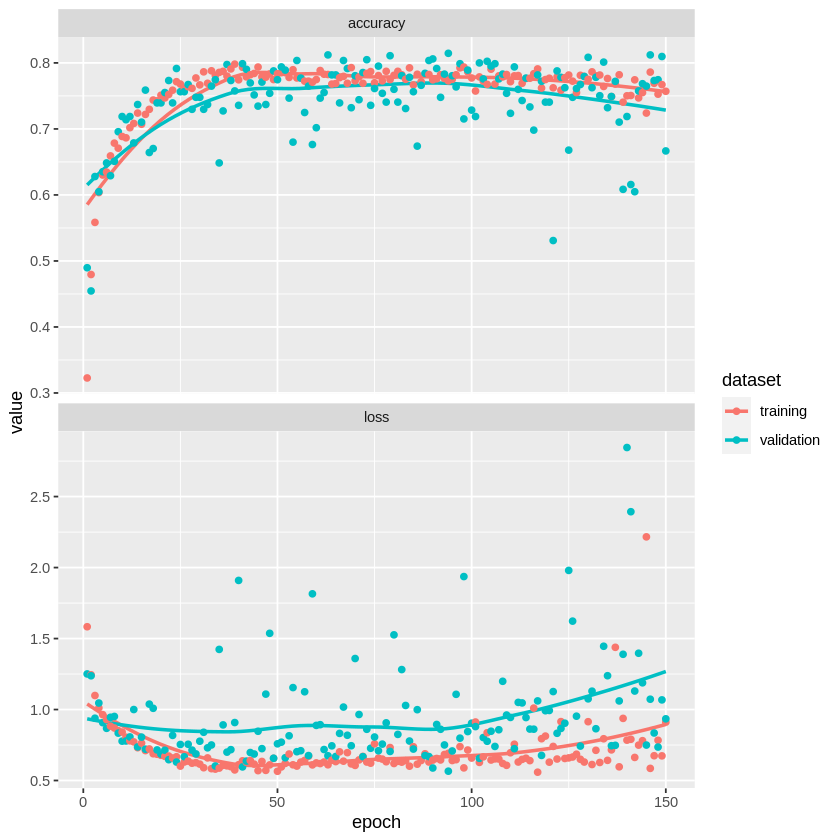

In [29]:
history3 %>%
    pivot_longer(cols=-epoch) %>%
    mutate(dataset = ifelse(str_detect(name, "val"), "validation", "training"),
           type=ifelse(str_detect(name, "acc"), "accuracy", "loss")) %>%
    filter(value < 3) %>% # remove a few outliers
    ggplot(aes(x=epoch, y=value, color=dataset)) +
        geom_smooth(se=FALSE) +
        geom_point() +
        facet_wrap(~type, scales = "free_y", ncol=1) 

    

Looks like we max out accuracy on the validation set at about 50 epochs.  

Let's load that model and see how it does

In [31]:
drive_download("DeepLearning/Flowers/flowers_model3_ep50.hdf5")
model3 <- load_model_hdf5("flowers_model3_ep50.hdf5")

Auto-refreshing stale OAuth token.

File downloaded:
  * flowers_model3_ep50.hdf5
Saved locally as:
  * flowers_model3_ep50.hdf5



In [32]:
results <- model3 %>% evaluate(test_generator3)
results %>% round(3)


loss   acc 
0.655 0.812

## Next steps:

dropout layers and/or regularization